# **Valor en Riesgo (VaR) en el Tipo de Cambio en Honduras**
## Análisis utilizando VaR Histórico y Simulación de Montecarlo

Este notebook cubre los conceptos y cálculos del Valor en Riesgo (VaR) utilizando diferentes métodos. El objetivo de este notebook es calcular el VaR sobre el tipo de cambio para poder analizar las posibles pérdidas en las inversiones en dólares, ya sea para inversores independientes, institutos de previsión o empresas. Se incluirán los siguientes tópicos:

1. ¿Qué es el VaR?
2. VaR Histórico
3. VaR por Simulación de Montecarlo

# ¿Qué es el Var?

El Valor en Riesgo (VaR) es una medida utilizada en finanzas para cuantificar el riesgo de una cartera de inversiones. Representa la pérdida máxima esperada durante un horizonte temporal específico con un nivel de confianza dado. El VaR se define así: Sea $ {\displaystyle X} $ una distribución de ganancias y pérdidas (pérdidas negativas y ganancias positivas). El VaR al nivel ${\displaystyle \alpha \in (0,1)} $ es el número más pequeño ${\displaystyle y}$ tal que la probabilidad de que ${\displaystyle Y:=-X}$ no exceda ${\displaystyle y}$ es al menos ${\displaystyle 1-\alpha }$. Matemáticamente, ${\displaystyle \operatorname {VaR} _{\alpha }(X)}$ es el $ {\displaystyle (1-\alpha )}$-cuantil de ${\displaystyle Y}$, es decir


${\displaystyle {\text{VaR}}_{\alpha }(X)=-\inf\{x\in \mathbb {R} :F_{X}(x)>\alpha \}=F_{Y}^{-1}(1-\alpha )} $


Esta es la definición más general del VaR y las dos identidades anteriores son equivalentes. Sin embargo esta fórmula no puede ser usada de manera directa para hacer cálculos a menos que se asuma que ${\displaystyle X}$ tiene una distribución paramétrica.

El VaR mide la cantidad máxima que podrías perder en un horizonte temporal dado (por ejemplo, un día) con un cierto nivel de confianza. Si el VaR diario es de $\text{\$1,000}$ con un nivel de confianza del 95%, significa que hay un 95% de confianza de no perder más de $\text{\$1,000}$ en un día.

Existen varios métodos para calcular el VaR, que se discutirán en las siguientes secciones.


# 0. Configuración del Ambiente

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import seaborn as sns
import random
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from scipy.stats import norm
from IPython.display import clear_output
#Las siguientes librerías se utilizan para ajustar distribuciones a los datos y para manejar archivos Excel, respectivamente
!pip install xlrd
!pip install fitter
import ssl  # Import the ssl module

In [2]:
#Se verifica que se tengan las versiones correctas de cada librería
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.1.4
------
Name: numpy
Version: 1.26.4
        Name: lapack-lite
        Name: tempita
        Name: dragon4
        Name: libdivide
        Name: Meson
        Name: spin
        Name: OpenBLAS
        Name: LAPACK
        Name: GCC runtime library
        Version 3.1, 31 March 2009
                               Version 3, 29 June 2007
          5. Conveying Modified Source Versions.
          14. Revised Versions of this License.
        Name: libquadmath
------
Name: matplotlib
Version: 3.9.2


# 1. Obtención de datos

In [3]:
# Creación de un contexto SSL no verificado
ssl._create_default_https_context = ssl._create_unverified_context
# Se extraen los datos directamente del Banco Central de Honduras, como ente oficial que fija el tipo de cambio
tipo_de_cambio = pd.read_excel('https://www.bch.hn/estadisticos/GIE/LIBTipo%20de%20cambio/Precio%20Promedio%20Diario%20del%20D%C3%B3lar.xlsx')
portfolio_value_USD_IVM = 10000000

In [4]:
#Se muestra el dataset antes de hacer cualquier tratamiento
tipo_de_cambio

,Banco Central de Honduras,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Subgerencia de Estudios Económicos,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Precio Promedio del Dólar de los Estados Unido...,NaN,NaN,NaN,NaN
3,Serie Diaria 2000-2024,NaN,NaN,NaN,NaN
4,(Lempiras por US$1.00),NaN,NaN,NaN,NaN
...,...,...,...,...,...
6510,1/ Corresponde al Tipo de Cambio de Referencia...,NaN,NaN,NaN,NaN
6511,"2/ El tipo de cambio mensual, es el promedio s...",NaN,NaN,NaN,NaN
6512,3/ Promedio simple de los días transcurridos.,NaN,NaN,NaN,NaN
6513,Fecha de actualización: 23/08/2024,NaN,NaN,NaN,NaN


Se observan registros que no muestran datos, pero sabemos que no es así, por lo que se mostrarán los primeros 15 registros e información sobre el dataset

In [5]:
tipo_de_cambio.head(15)

,Banco Central de Honduras,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Subgerencia de Estudios Económicos,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Precio Promedio del Dólar de los Estados Unido...,NaN,NaN,NaN,NaN
3,Serie Diaria 2000-2024,NaN,NaN,NaN,NaN
4,(Lempiras por US$1.00),NaN,NaN,NaN,NaN
5,Fecha,Compra 1/,Venta,NaN,NaN
6,Enero 2/,14.536667,14.717143,NaN,NaN
7,2000-01-03 00:00:00,14.5,14.68,NaN,NaN
8,2000-01-04 00:00:00,14.5,14.69,NaN,NaN
9,2000-01-05 00:00:00,14.51,14.69,NaN,NaN


In [6]:
tipo_de_cambio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Banco Central de Honduras  6514 non-null   object 
 1   Unnamed: 1                 6505 non-null   object 
 2   Unnamed: 2                 6505 non-null   object 
 3   Unnamed: 3                 0 non-null      float64
 4   Unnamed: 4                 1 non-null      object 
dtypes: float64(1), object(4)
memory usage: 254.6+ KB


Se observa que los datos contienen dos columnas adicionales sin información útil, así como filas que representan promedios mensuales que no son relevantes para el análisis. Por otro lado, las columnas no están con el tipo correspondiente a los datos por lo que procederemos a hacer la limpieza y transformación de los mismos para tener un dataset limpio y adecuado para el análisis del VaR.

# 2. Limpieza de Datos


In [7]:
#Comenzaremos creando una copia de los datos
tipo_de_cambio_limpio = tipo_de_cambio.copy()

# A partir de aquí haremos la limpieza de los mismos, eliminando algunas filas
# que no tienen información solo dejando el tipo de cambio, de igual forma las
# columnas que no traen información. Las filas que eliminamos al inicio corresponden
# a encabezados adicionales y promedios que no son útiles para el análisis de VaR.
tipo_de_cambio_limpio.columns = tipo_de_cambio_limpio.iloc[5]
tipo_de_cambio_limpio.drop(tipo_de_cambio_limpio.index[0:6], inplace=True)
tipo_de_cambio_limpio.drop(tipo_de_cambio_limpio.columns[[3, 4]], axis='columns', inplace=True)
tipo_de_cambio_limpio.columns = ['Fecha', 'Compra', 'Venta']
tipo_de_cambio_limpio.columns.name = ''
tipo_de_cambio_limpio.dropna(subset = ['Venta'], inplace = True)

# Ahora procederemos a cambiar los tipos de cada columna y eliminar filas que sirven de promedio mensual
# Las fechas se convierten al formato datetime para un mejor manejo temporal, y eliminamos filas
# que contienen promedios mensuales que no son útiles en este contexto.
tipo_de_cambio_limpio['Fecha'] = pd.to_datetime(tipo_de_cambio_limpio['Fecha'], errors='coerce')
tipo_de_cambio_limpio.dropna(subset = ['Fecha'], inplace = True)
# Aquí hacemos el tipeo de las columnas de compra y venta para garantizar precisión en los cálculos futuros
tipo_de_cambio_limpio = tipo_de_cambio_limpio.astype({'Compra': 'float64', 'Venta': 'float64'})
# Reindexamos el índice con las fechas para un mejor tratamiento temporal de los datos.
# Eliminamos la fecha como columna, porque ya está como índice
tipo_de_cambio_limpio.index = tipo_de_cambio_limpio['Fecha']
tipo_de_cambio_limpio.drop(tipo_de_cambio_limpio.columns[0], axis='columns', inplace=True)
clear_output()
tipo_de_cambio_limpio

# Validamos la consistencia de los datos limpios mostrando una descripción de las estadísticas básicas
tipo_de_cambio_limpio.describe()

,Compra,Venta
count,6208.000000,6208.000000
mean,20.508216,20.663684
std,3.031454,3.026899
min,14.500000,14.680000
25%,18.895100,19.026800
50%,19.290850,19.425800
75%,23.785250,23.951750
max,24.835700,25.009500


In [8]:
#Veremos la información que tiene nuestro Dataset ahora que ya está limpio
tipo_de_cambio_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6208 entries, 2000-01-03 to 2024-08-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Compra  6208 non-null   float64
 1   Venta   6208 non-null   float64
dtypes: float64(2)
memory usage: 145.5 KB


In [9]:
#Calcularemos los cambios diarios o rentabilidad diaria mediante logaritmos para cada tipo de cambio y así
#observar su comportamiento como distribución
tipo_de_cambio_limpio['Rentabilidad_Compra'] = np.log(tipo_de_cambio_limpio['Compra'] / tipo_de_cambio_limpio['Compra'].shift(1))
tipo_de_cambio_limpio['Rentabilidad_Venta'] = np.log(tipo_de_cambio_limpio['Venta'] / tipo_de_cambio_limpio['Venta'].shift(1))
#Guardaremos el archivo limpio, para poder usarlo en diferentes contextos
tipo_de_cambio_limpio.to_excel('Tipo de Cambio_'+tipo_de_cambio_limpio.tail(1).index.strftime("%d-%m-%Y").format()[0]+'.xlsx')
#Veamos una pequeña descripción de los datos ya tratados y con sus rentabilidades agregadas
tipo_de_cambio_limpio.describe()

,Compra,Venta,Rentabilidad_Compra,Rentabilidad_Venta
count,6208.000000,6208.000000,6207.000000,6207.000000
mean,20.508216,20.663684,0.000086,0.000085
std,3.031454,3.026899,0.000402,0.000480
min,14.500000,14.680000,-0.012017,-0.006150
25%,18.895100,19.026800,0.000000,-0.000013
50%,19.290850,19.425800,0.000007,0.000011
75%,23.785250,23.951750,0.000166,0.000188
max,24.835700,25.009500,0.006788,0.006174


# 3. Visualización de Datos

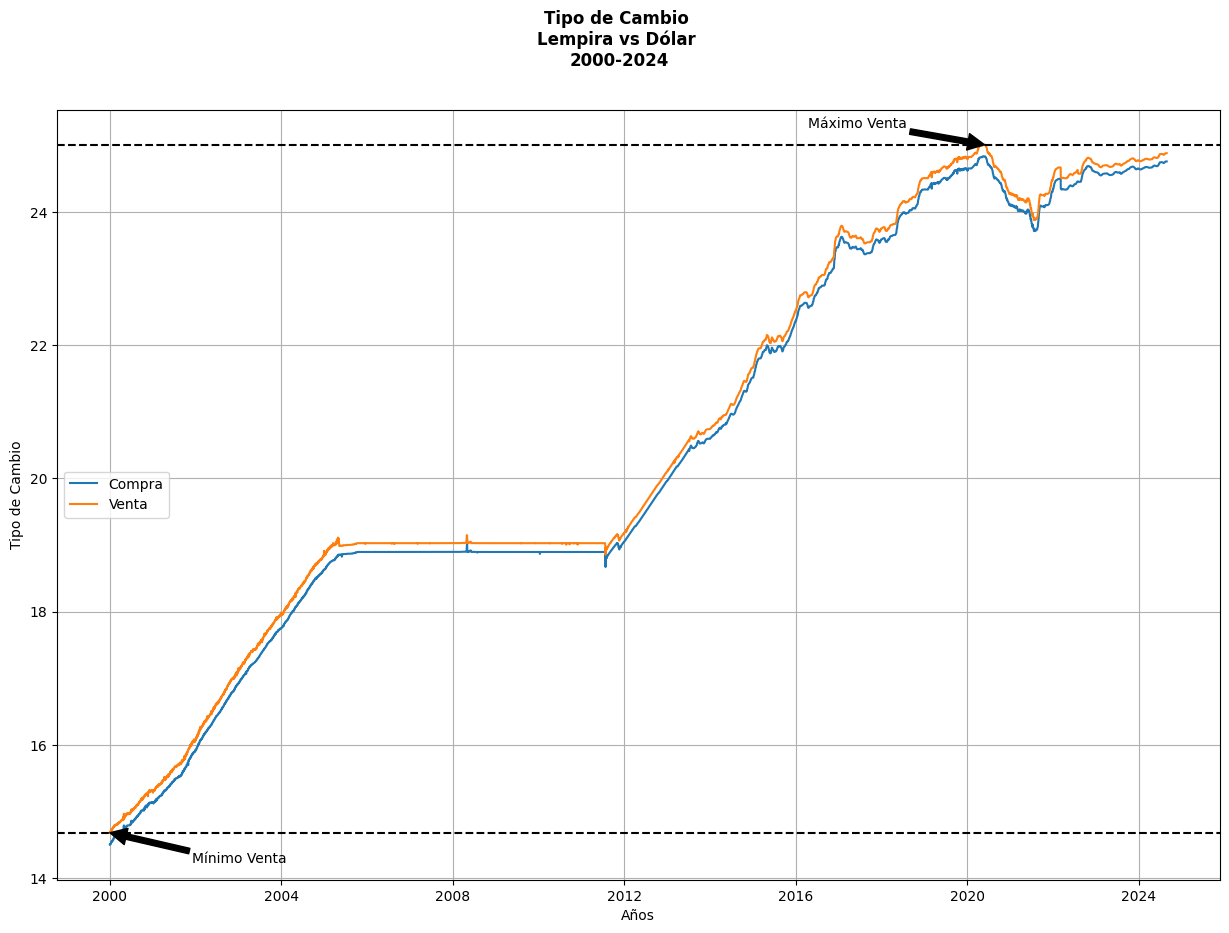

In [10]:
# Crearemos un gráfico de linea de los valores de compra y venta a través del tiempo
plt.rc('figure', figsize = (15,10))
plt.suptitle('Tipo de Cambio \nLempira vs Dólar \n2000-2024', ha='center', fontweight ="bold")
plt.plot(tipo_de_cambio_limpio.index, tipo_de_cambio_limpio['Compra'], label='Compra',)
plt.plot(tipo_de_cambio_limpio.index, tipo_de_cambio_limpio['Venta'], label='Venta')
plt.xlabel('Años')
plt.ylabel('Tipo de Cambio')

# Identificamos los puntos máximos y mínimos de la serie temporal
x1 = tipo_de_cambio_limpio['Venta'].idxmax()
y1 = max(tipo_de_cambio_limpio['Venta'])
x2 = tipo_de_cambio_limpio['Venta'].idxmax() - dt.timedelta(days=1500)
y2 = max(tipo_de_cambio_limpio['Venta']) + 0.25
plt.annotate("Máximo Venta", xy=(x1,y1), fontsize=10, xytext=(x2,y2), arrowprops=dict(facecolor='k'))

x1 = tipo_de_cambio_limpio['Venta'].idxmin()
y1 = min(tipo_de_cambio_limpio['Venta'])
x2 = tipo_de_cambio_limpio['Venta'].idxmin() + dt.timedelta(days=700)
y2 = min(tipo_de_cambio_limpio['Venta']) - 0.45
plt.annotate("Mínimo Venta", xy=(x1,y1), fontsize=10, xytext=(x2,y2), arrowprops=dict(facecolor='k'))

# Las líneas horizontales marcan el rango entre el máximo y el mínimo, destacando la volatilidad del tipo de cambio.
plt.axhline(max(tipo_de_cambio_limpio['Venta']), color = 'k', linestyle='--')
plt.axhline(min(tipo_de_cambio_limpio['Venta']), color = 'k', linestyle='--')

plt.legend(loc = 'center left')
clear_output()
plt.grid()
plt.show()

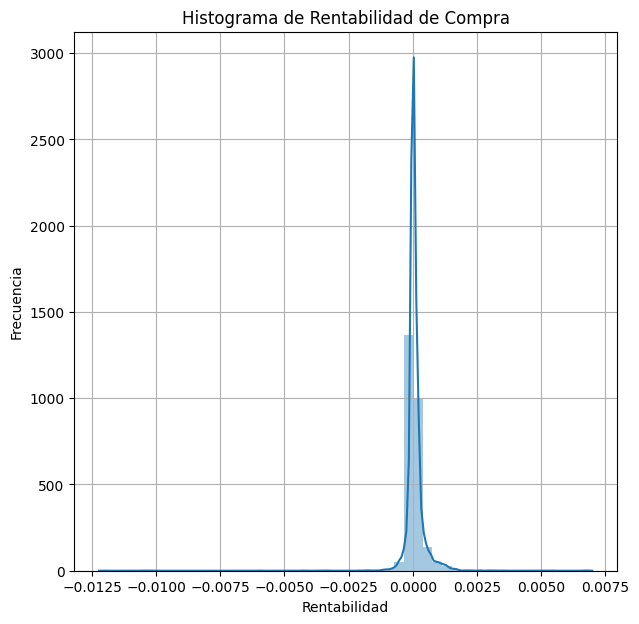

In [11]:
# Miremos el histograma de los datos de rentabilidad_compra
plt.rc('figure', figsize = (7,7))
sns.distplot(tipo_de_cambio_limpio['Rentabilidad_Compra'])
plt.title('Histograma de Rentabilidad de Compra')
plt.xlabel('Rentabilidad')
plt.ylabel('Frecuencia')
clear_output()
plt.grid()
plt.show()

<ipython-input-12-74e319af1b8c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tipo_de_cambio_limpio['Rentabilidad_Venta'])


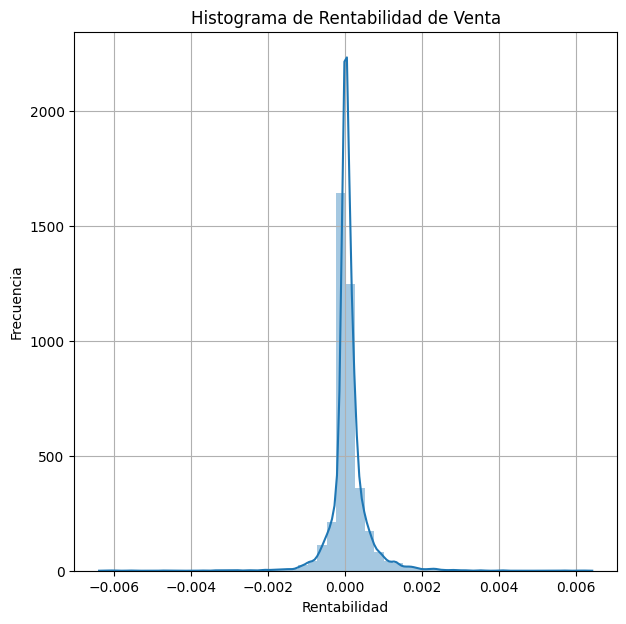

In [12]:
# Miremos el histograma de los datos de rentabilidad_venta
plt.rc('figure', figsize = (7,7))
sns.distplot(tipo_de_cambio_limpio['Rentabilidad_Venta'])
plt.title('Histograma de Rentabilidad de Venta')
plt.xlabel('Rentabilidad')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


Estos histogramas nos permiten observar la distribución de los rendimientos diarios de compra y venta del tipo de cambio. Como observamos, la distribución no parece ser normal, lo cual tiene implicaciones importantes para la estimación del VaR que exploraremos en secciones posteriores.

# 4. Pruebas de Normalidad
Se harán pruebas de normalidad sobre la columna de Rentabilidad_Compra ya que el valor de compra es el valor al cual las instituciones financieras compran los dólares y esto con el objetivo de calcular el VaR sobre dichos datos.

In [13]:
#Se filtran las fechas ya que las pruebas de Kolmogorov no funcionan si hay más de
#5,000 datos utilizaremos los datos de los últimos 6 años
seleccion = (tipo_de_cambio_limpio.index > "2018-12-31") & (tipo_de_cambio_limpio.index < "2024-07-01")
tipo_de_cambio_filtrado = tipo_de_cambio_limpio.loc[seleccion]
log_returns = tipo_de_cambio_filtrado['Rentabilidad_Compra'].dropna()
log_returns.head(10)

,Rentabilidad_Compra
Fecha,
2019-01-02,0.000000
2019-01-03,0.000021
2019-01-04,-0.000004
2019-01-07,-0.000004
2019-01-08,-0.000021
2019-01-09,-0.000021
2019-01-10,-0.000021
2019-01-11,-0.000025
2019-01-14,-0.000021


In [14]:
#Aquí escribimos los días del horizonte temporal para calcular el VaR
dias = 1
historical_x_day_returns = log_returns.rolling(window=dias).sum()
historical_x_day_returns = historical_x_day_returns.dropna()
historical_x_day_returns.head(10)

,Rentabilidad_Compra
Fecha,
2019-01-02,0.000000
2019-01-03,0.000021
2019-01-04,-0.000004
2019-01-07,-0.000004
2019-01-08,-0.000021
2019-01-09,-0.000021
2019-01-10,-0.000021
2019-01-11,-0.000025
2019-01-14,-0.000021


In [15]:
# Calculamos la matriz de covarianzas para evaluar la variabilidad en los retornos
#(Esto es de utilidad cuando se quiere calcular el VaR de diferentes instrumentos
#en un portafolio, pero también aplica para un solo instrumento)
cov_matrix = historical_x_day_returns.cov(historical_x_day_returns) * 252
media = historical_x_day_returns.mean()
desviacion_estandar = np.sqrt(cov_matrix)

print(cov_matrix, media, desviacion_estandar)

2.750433286826574e-05 1.1909808616768009e-05 0.005244457347358804


Se quiere conocer si la distribución de las ganancias y pérdidas de la compra es normal, es decir, si la columna de Rentabilidad_Compra sigue una distribución normal. Esto es crucial, ya que la normalidad de los datos impacta la elección del método de cálculo del VaR. Veremos de forma gráfica la distribución y luego verificaremos nuestra hipótesis mediante las pruebas de Shapiro y de Kolmogorov.

### Normalidad de manera gráfica
Primero se verá nuevamente el histograma de la distribución, así como una "prueba de Normalidad gráfica" para estimar si corresponde a la distribución Normal

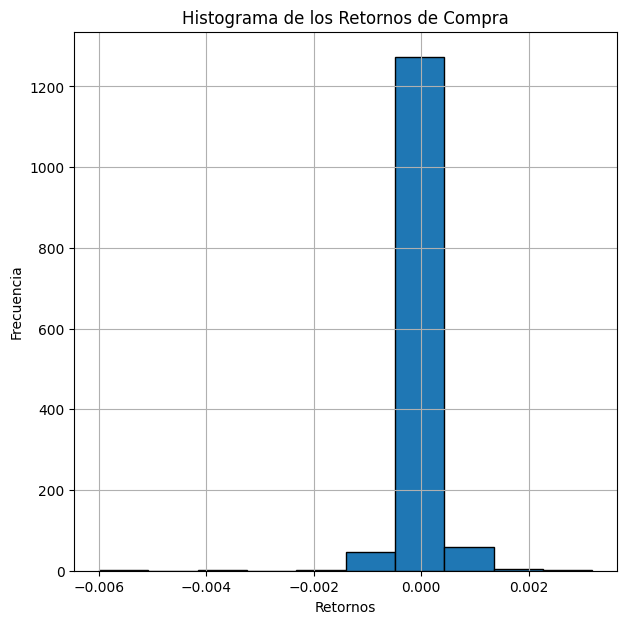

In [16]:
plt.hist(historical_x_day_returns, edgecolor = 'black', linewidth=1)
plt.title('Histograma de los Retornos de Compra')
plt.xlabel('Retornos')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

A continuación, se creará el gráfico Quantil-Quantile para corroborar normalidad de los datos

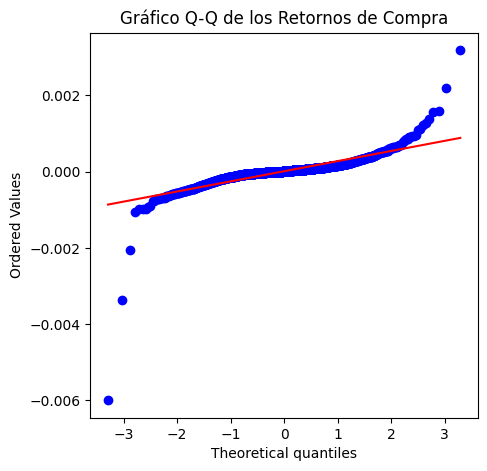

In [17]:
import pylab
import scipy.stats as stats

plt.rc('figure', figsize = (5,5))
stats.probplot(historical_x_day_returns, dist='norm', plot=pylab)
plt.title('Gráfico Q-Q de los Retornos de Compra')
pylab.show()

Las gráficas no se alinean, por lo tanto, no parece que la distribución sea normal, ya que tiene varios puntos fuera de la recta y la distribución tampoco simula la campana de Gauss, ya que tiene un pico en el cero. Vamos a confirmar nuestras ideas mediante la prueba de normalidad de Shapiro y de Kolmogorov.

### Prueba de Shapiro
En el test de Shapiro-Wilks si se tiene que p_value>0.05 significa que la distribución puede ser normal, de lo contrario (p_value<0.05) significa con seguridad de que no es una distribución normal.

In [18]:
from scipy.stats import shapiro
estadistico, p_value = shapiro(historical_x_day_returns)
print('Estadístico= %.3f, p_value= %.3f' % (estadistico, p_value))
if p_value > 0.05:
    print("La prueba de Shapiro no rechaza la hipótesis nula, la distribución normal ajusta bien a los datos.")
else:
    print("La prueba de Shapiro rechaza la hipótesis nula, la distribución normal no ajusta bien a los datos.")

Estadístico= 0.652, p_value= 0.000
La prueba de Shapiro rechaza la hipótesis nula, la distribución normal no ajusta bien a los datos.


###Prueba de Kolmogorov
En el test de Kolmogorov si se tiene que p_value>0.05 significa que la distribución puede ser normal, de lo contrario (p_value<0.05) significa con seguridad de que no es una distribución normal.

In [19]:
from scipy import stats
estadistico, p_value = stats.kstest(historical_x_day_returns, stats.norm.cdf, args=(historical_x_day_returns.mean(),historical_x_day_returns.std()))
if p_value > 0.05:
    print("La prueba de Kolmogorov-Smirnov no rechaza la hipótesis nula, la distribución normal ajusta bien a los datos.")
else:
    print("La prueba de Kolmogorov-Smirnov rechaza la hipótesis nula, la distribución normal no ajusta bien a los datos.")

La prueba de Kolmogorov-Smirnov rechaza la hipótesis nula, la distribución normal no ajusta bien a los datos.


Con ambas pruebas se puede afirmar que la distribución no es normal, lo cual nos lleva a buscar una mejor distribución para los datos de Rentabilidad_Compra utilizando técnicas como Fitter. Dicha librería realiza pruebas sobre varias distribuciones estadísticas para conocer a qué distribución se aproximan los datos.

###Fitter

Fitter es una librería de Python que facilita el ajuste de una gran cantidad de distribuciones estadísticas a un conjunto de datos, para encontrar la distribución que mejor se ajuste. La librería puede probar múltiples distribuciones de manera automática y proporcionar un resumen de cuál de ellas se adapta mejor a los datos basándose en varios criterios de ajuste.

Características principales de Fitter:
1. Ajuste de múltiples distribuciones: Fitter prueba automáticamente varias distribuciones estadísticas, tanto continuas como discretas, y ajusta los datos a estas distribuciones.
2. Evaluación del ajuste: Calcula el error cuadrático medio, el valor de la función de densidad acumulada y otros criterios para determinar la mejor distribución.
3. Visualización: Proporciona gráficos que muestran cómo las diferentes distribuciones se ajustan a los datos.

Se utilizará Fitter para encontrar a qué distribución común se aproximan esos datos y se corroborará con la prueba de Kolmogorov-Smirnov.
Este análisis es crucial porque la precisión del VaR mediante simulación de Montecarlo depende en gran medida de que la distribución elegida refleje con precisión los datos históricos. Una distribución incorrecta podría subestimar o sobrestimar el riesgo.

               sumsquare_error         aic         bic  kl_div  ks_statistic  \
norminvgauss      71008.325952 -113.666465  -92.732643     inf      0.026808   
tukeylambda       73977.878691 -235.739025 -220.038658     inf      0.045940   
nct               74970.866396 -263.832903 -242.899082     inf      0.026740   
johnsonsu         92176.177895 -201.342278 -180.408456     inf      0.027297   
genhyperbolic    263203.340462   30.792324   56.959601     inf      0.026767   

               ks_pvalue  
norminvgauss    0.267723  
tukeylambda     0.005597  
nct             0.270434  
johnsonsu       0.248816  
genhyperbolic   0.269350  


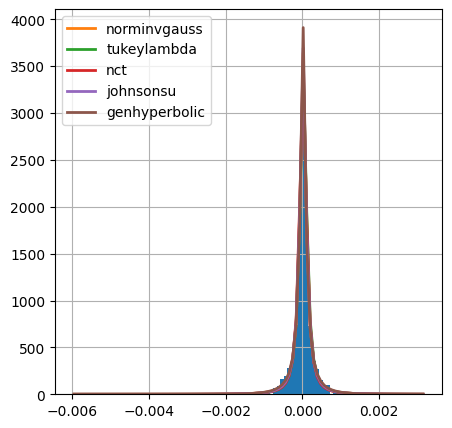

In [20]:
from fitter import Fitter, get_common_distributions
# Inicializando el objeto Fitter
#common_distributions = get_common_distributions()
f = Fitter(historical_x_day_returns)

# Se hace el ajuste con las distribuciones más conocidas
f.fit()

# Se imprime el resumen de las distribuciones más comunes que se ajustan a la data
f.summary()

# Se imprime el resumen de las distribuciones más comunes que se ajustan a la data
plt.rc('figure', figsize = (7,7))
print(f.summary())

In [21]:
# Obtener la mejor distribución
best_distribution = f.get_best(method='sumsquare_error')
best_dist_name = list(best_distribution.keys())[0]
best_params = best_distribution[best_dist_name]

print(f"Mejor distribución: {best_dist_name}")
print(f"Parámetros: {best_params}")

Mejor distribución: norminvgauss
Parámetros: {'a': 0.09174420256375293, 'b': -0.003039349416134567, 'loc': 1.5021245604752035e-05, 'scale': 9.43692302327975e-05}


In [22]:
# Realizar prueba de Kolmogorov-Smirnov
ks_statistic, p_value = stats.kstest(historical_x_day_returns, best_dist_name, args=tuple(best_params.values()))
print(f"KS estadístico: {ks_statistic}, p-valor: {p_value}")

if p_value > 0.05:
    print(f"La prueba de Kolmogorov-Smirnov no rechaza la hipótesis nula, la distribución {best_dist_name} ajusta bien a los datos.")
else:
    print(f"La prueba de Kolmogorov-Smirnov rechaza la hipótesis nula, la distribución {best_dist_name} no ajusta bien a los datos.")

KS estadístico: 0.026807679708195753, p-valor: 0.26772323862515857
La prueba de Kolmogorov-Smirnov no rechaza la hipótesis nula, la distribución norminvgauss ajusta bien a los datos.


Se observa que la distribución elegida por Fitter encaja con los datos de Rentabilidad_Compra, usaremos esta distribución para calcular el VaR vía simulación de Montecarlo.

# 5. Calculando el VaR



> Se calculará el VaR histórico y el VaR mediante simulación de Montecarlo a diferentes niveles de confianza sobre la compra de dólares para tener más opciones sobre que pérdida esperada se podría tener en posiciones en dicha moneda. Tendremos en cuenta que la distribución de ganancias y pérdidas de venta (Rentabilidad_Compra) no es normal para calcular el VaR mediante simulación de Montecarlo.



### VaR Histórico

El VaR histórico no asume ninguna distribución específica y se basa en los rendimientos históricos de la cartera. Aquí se calculará el VaR histórico utilizando los datos de precios históricos.


In [23]:
niveles_de_confianza = [0.9, 0.95, 0.99]
VaRs = []
for cl in niveles_de_confianza:
  VaR = -np.percentile(historical_x_day_returns, 100 - (cl * 100)) * portfolio_value_USD_IVM
  VaRs.append(VaR)

In [24]:
print(f'{"Nivel de Confianza":<20} {"Valor en Riesgo":<20}')
print('-' * 40)

#Imprime cada nivel de confianza y su respectivo valor del VaR
for cl, VaR in zip(niveles_de_confianza, VaRs):
  print(f'{"":<5} {cl * 100:>4.0f}%: {"":<8} ${VaR:>10,.2f}')

Nivel de Confianza   Valor en Riesgo     
----------------------------------------
        90%:          $  2,406.02
        95%:          $  4,181.80
        99%:          $  7,029.57


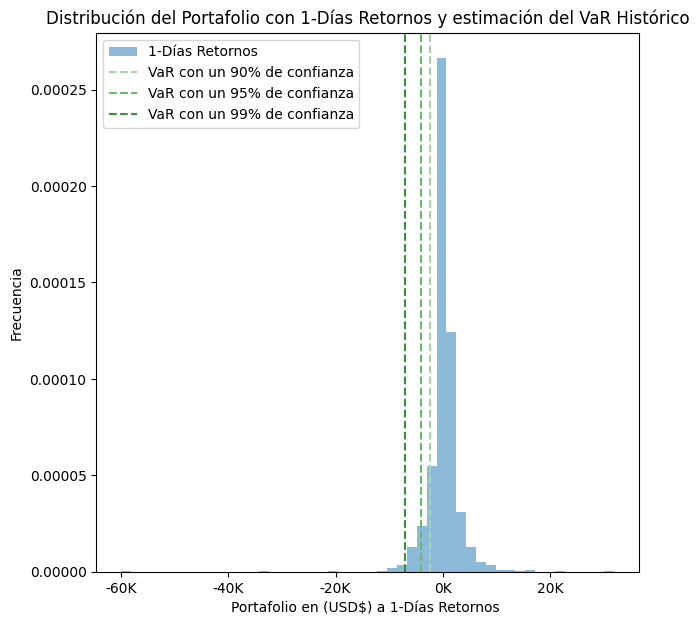

In [25]:
# Función para formatear los valores en los ejes
def millones(x, pos):
    'El argumento pos no es utilizado en este caso'
    return '%1.0fK' % (x * 1e-3)

formatter = FuncFormatter(millones)

# Colores de la misma familia con diferentes intensidades (Verde)
colors = ['#a5d6a7', '#66bb6a', '#388e3c']  # Verde claro, verde medio, verde oscuro

#Graficamos el histograma
plt.hist(historical_x_day_returns * portfolio_value_USD_IVM, bins=50, density=True, alpha=0.5, label=f'{dias}-Días Retornos')

#Añadimos líneas verticales que representa el VaR para cada nivel de confianza
for cl, VaR, color in zip(niveles_de_confianza, VaRs, colors):
  plt.axvline(x=-VaR, linestyle='--', color=color, label= 'VaR con un {}% de confianza'.format(int(cl*100)))

plt.xlabel(f'Portafolio en (USD$) a {dias}-Días Retornos ')
plt.ylabel('Frecuencia')
plt.title(f'Distribución del Portafolio con {dias}-Días Retornos y estimación del VaR Histórico')
# Configurar el eje x para mostrar en miles de dólares
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

### VaR vía Simulación Montecarlo

#### ¿Qué es el Método de Montecarlo?

El Método de Montecarlo es una técnica estadística que utiliza la generación de números aleatorios para simular una amplia gama de escenarios posibles en un modelo financiero.

En el contexto del Valor en Riesgo (VaR), la simulación de Montecarlo implica generar un gran número de posibles rendimientos futuros de una cartera o activo basado en una distribución de probabilidad determinada. Luego, se calculan las pérdidas correspondientes a cada uno de estos rendimientos simulados. El VaR se estima como el percentil específico de esta distribución de pérdidas, lo que proporciona una medida del riesgo en función de las simulaciones realizadas.

#### Simulaciones

Correremos 10,000 simulaciones para estimar el VaR. La razón por la cual se elige un número tan elevado de simulaciones es que el Método de Montecarlo se basa en la generación aleatoria de escenarios de mercado, lo cual implica que cuanto mayor sea el número de simulaciones, más representativa será la distribución de posibles resultados.

Utilizar 10,000 simulaciones permite capturar una amplia gama de escenarios posibles, incluidos aquellos que son menos comunes pero que pueden tener un impacto significativo en el cálculo del VaR. Este número de simulaciones ayuda a suavizar las fluctuaciones que podrían resultar de un número más reducido de simulaciones, lo que a su vez mejora la precisión y estabilidad del VaR estimado. Sin embargo, es importante balancear el número de simulaciones con la capacidad computacional disponible para evitar tiempos de procesamiento excesivos.

En este notebook se usan 2 escenarios, el primero obteniendo la distribución a través de los rendimientos históricos y el segundo con la mejor distribución ajustada por Fitter para las simulaciones.

In [26]:
# Correremos 10,000 simulaciones
simulations = 10000

# Simularemos los rendimientos históricos
random.seed(123)
scenarioReturn = np.random.choice(historical_x_day_returns, size=simulations)

In [27]:
#Calcularemos las pérdidas/ganancias de la cartera
simulated_portfolio_values = portfolio_value_USD_IVM * np.exp(scenarioReturn)
simulated_losses = portfolio_value_USD_IVM - simulated_portfolio_values

In [28]:
niveles_de_confianza = [0.9, 0.95, 0.99]
VaRs = []
for cl in niveles_de_confianza:
  VaR = -np.percentile(simulated_losses, 100 - (cl * 100))
  VaRs.append(VaR)

In [29]:
print(f'{"Nivel de Confianza":<20} {"Valor en Riesgo":<20}')
print('-' * 40)

#Imprime cada nivel de confianza y su respectivo valor del VaR
for cl, VaR in zip(niveles_de_confianza, VaRs):
  print(f'{"":<5} {cl * 100:>4.0f}%: {"":<8} ${VaR:>10,.2f}')

Nivel de Confianza   Valor en Riesgo     
----------------------------------------
        90%:          $  2,601.09
        95%:          $  4,109.18
        99%:          $  9,017.13


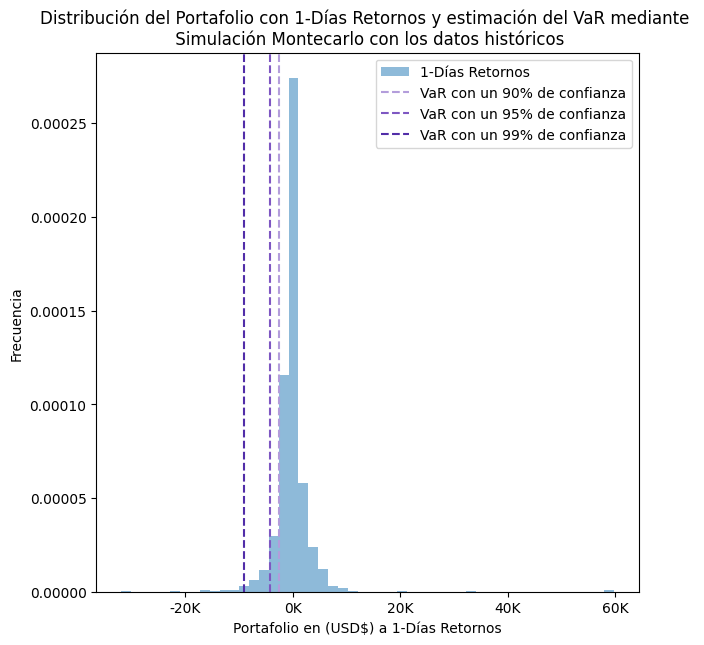

In [30]:
# Colores de la misma familia con diferentes intensidades (Morado)
colors = ['#b39ddb', '#7e57c2', '#512da8']  # Morado claro, morado medio, morado oscuro

#Graficamos el histograma
plt.hist(simulated_losses, bins=50, density=True, alpha=0.5, label=f'{dias}-Días Retornos')

#Añadimos líneas verticales que representa el VaR para cada nivel de confianza
for cl, VaR, color in zip(niveles_de_confianza, VaRs, colors):
  plt.axvline(x=-VaR, linestyle='--', color=color, label= 'VaR con un {}% de confianza'.format(int(cl*100)))

plt.xlabel(f'Portafolio en (USD$) a {dias}-Días Retornos')
plt.ylabel('Frecuencia')
plt.title(f'Distribución del Portafolio con {dias}-Días Retornos y estimación del VaR mediante \n Simulación Montecarlo con los datos históricos')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

Ahora procederemos a usar la distribución ajustada a los datos para las simulaciones:

In [31]:
from scipy.stats import norminvgauss
def random_norminvgauss():
  a = best_params['a']
  b = best_params['b']
  loc = best_params['loc']
  scale = best_params['scale']
  random.seed(123)
  return norminvgauss.rvs(a=a, b=b, loc=loc, scale=scale, size=1)[0]


# Correremos 10,000 simulaciones
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    scenarioReturn.append(random_norminvgauss())

scenarioReturn=np.array(scenarioReturn)

In [32]:
# Se limitarán los extremos de la distribución simulada para evitar datos extremadamente bajos
# pues la distribución norminvgauss tiene colas pesadas
# Valores extremos de los datos históricos
min_return = np.min(historical_x_day_returns)
max_return = np.max(historical_x_day_returns)

# Limitar los valores extremos a los valores extremos de los datos históricos
clipped_scenarioReturn = np.clip(scenarioReturn, min_return, max_return)

#Se simularán las pérdidas/ganancias de la cartera
simulated_portfolio_values = portfolio_value_USD_IVM * np.exp(clipped_scenarioReturn)
simulated_losses = portfolio_value_USD_IVM - simulated_portfolio_values

In [33]:
niveles_de_confianza = [0.9, 0.95, 0.99]
VaRs = []
for cl in niveles_de_confianza:
  VaR = -np.percentile(simulated_losses, 100 - (cl * 100))
  VaRs.append(VaR)

In [34]:
print(f'{"Nivel de Confianza":<20} {"Valor en Riesgo":<20}')
print('-' * 40)

#Imprime cada nivel de confianza y su respectivo valor del VaR
for cl, VaR in zip(niveles_de_confianza, VaRs):
  print(f'{"":<5} {cl * 100:>4.0f}%: {"":<8} ${VaR:>10,.2f}')

Nivel de Confianza   Valor en Riesgo     
----------------------------------------
        90%:          $  2,349.34
        95%:          $  3,845.64
        99%:          $  9,545.94


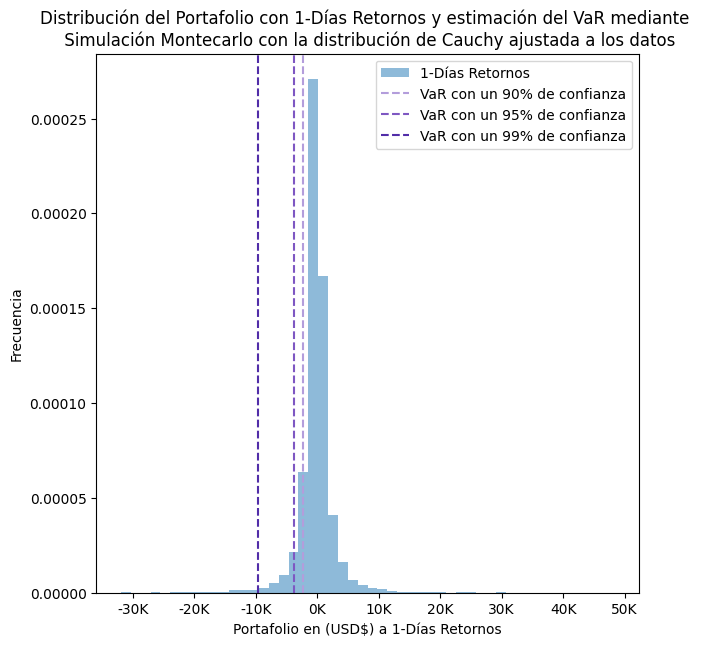

In [35]:
# Colores de la misma familia con diferentes intensidades (Morado)
colors = ['#b39ddb', '#7e57c2', '#512da8']  # Morado claro, morado medio, morado oscuro

#Graficamos el histograma
plt.hist(simulated_losses, bins=50, density=True, alpha=0.5, label=f'{dias}-Días Retornos')

#Añadimos líneas verticales que representa el VaR para cada nivel de confianza
for cl, VaR, color in zip(niveles_de_confianza, VaRs, colors):
  plt.axvline(x=-VaR, linestyle='--', color=color, label= 'VaR con un {}% de confianza'.format(int(cl*100)))

plt.xlabel(f'Portafolio en (USD$) a {dias}-Días Retornos')
plt.ylabel('Frecuencia')
plt.title(f'Distribución del Portafolio con {dias}-Días Retornos y estimación del VaR mediante \n Simulación Montecarlo con la distribución de Cauchy ajustada a los datos')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

# 6. Conclusiones



> 1. VaR Histórico:
El cálculo del VaR histórico ofrece una estimación basada en datos reales pasados, sin asumir ninguna distribución específica. Aunque este enfoque es sencillo y directo, puede ser limitado en su capacidad para capturar escenarios extremos o cambios en la volatilidad del mercado.

> 2. VaR por Simulación de Montecarlo:
La simulación de Montecarlo ofrece un análisis más flexible al modelar una gama más amplia de posibles escenarios futuros.
Este método es particularmente útil cuando los rendimientos no siguen una distribución normal, como se evidenció en los datos de tipo de cambio en Honduras.
Al comparar diferentes niveles de confianza, se observa cómo la precisión y robustez del VaR mejora con la utilización de una distribución ajustada a los datos históricos, lo que subraya la importancia de una adecuada modelización en la gestión de riesgos.

> 3. Comparación de Métodos: Ambos métodos proporcionan estimaciones valiosas del VaR, pero el método de Montecarlo ofrece una visión más profunda al considerar distribuciones no normales y escenarios extremos aunque requiere una mayor capacidad computacional y un modelado más cuidadoso.

# 7. Recomendaciones


> 1. Dado que los datos de rentabilidad de compra no siguen una distribución normal, se recomienda utilizar el método de Montecarlo con distribuciones ajustadas como herramienta principal para la estimación del VaR en el contexto del tipo de cambio en Honduras.

> 2. Se recomienda realizar un monitoreo constante de las condiciones del mercado y ajustar los modelos según sea necesario para mantener una estimación precisa del riesgo.